EDA guide: https://miykael.github.io/blog/2022/advanced_eda/

# EDA Analysis

## Imported files

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

Now that we know we have **45 floats** and **2 datetime** types, can display which features we have.

## Investigation of the data structure

It can be wise to investigate the dataset and visualize how it is structured.

/var/folders/y3/2mtrz03n77j2nhqjpj_67ptm0000gn/T/ipykernel_1378/3053554035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time'] = pd.to_datetime(df_filtered['time'])


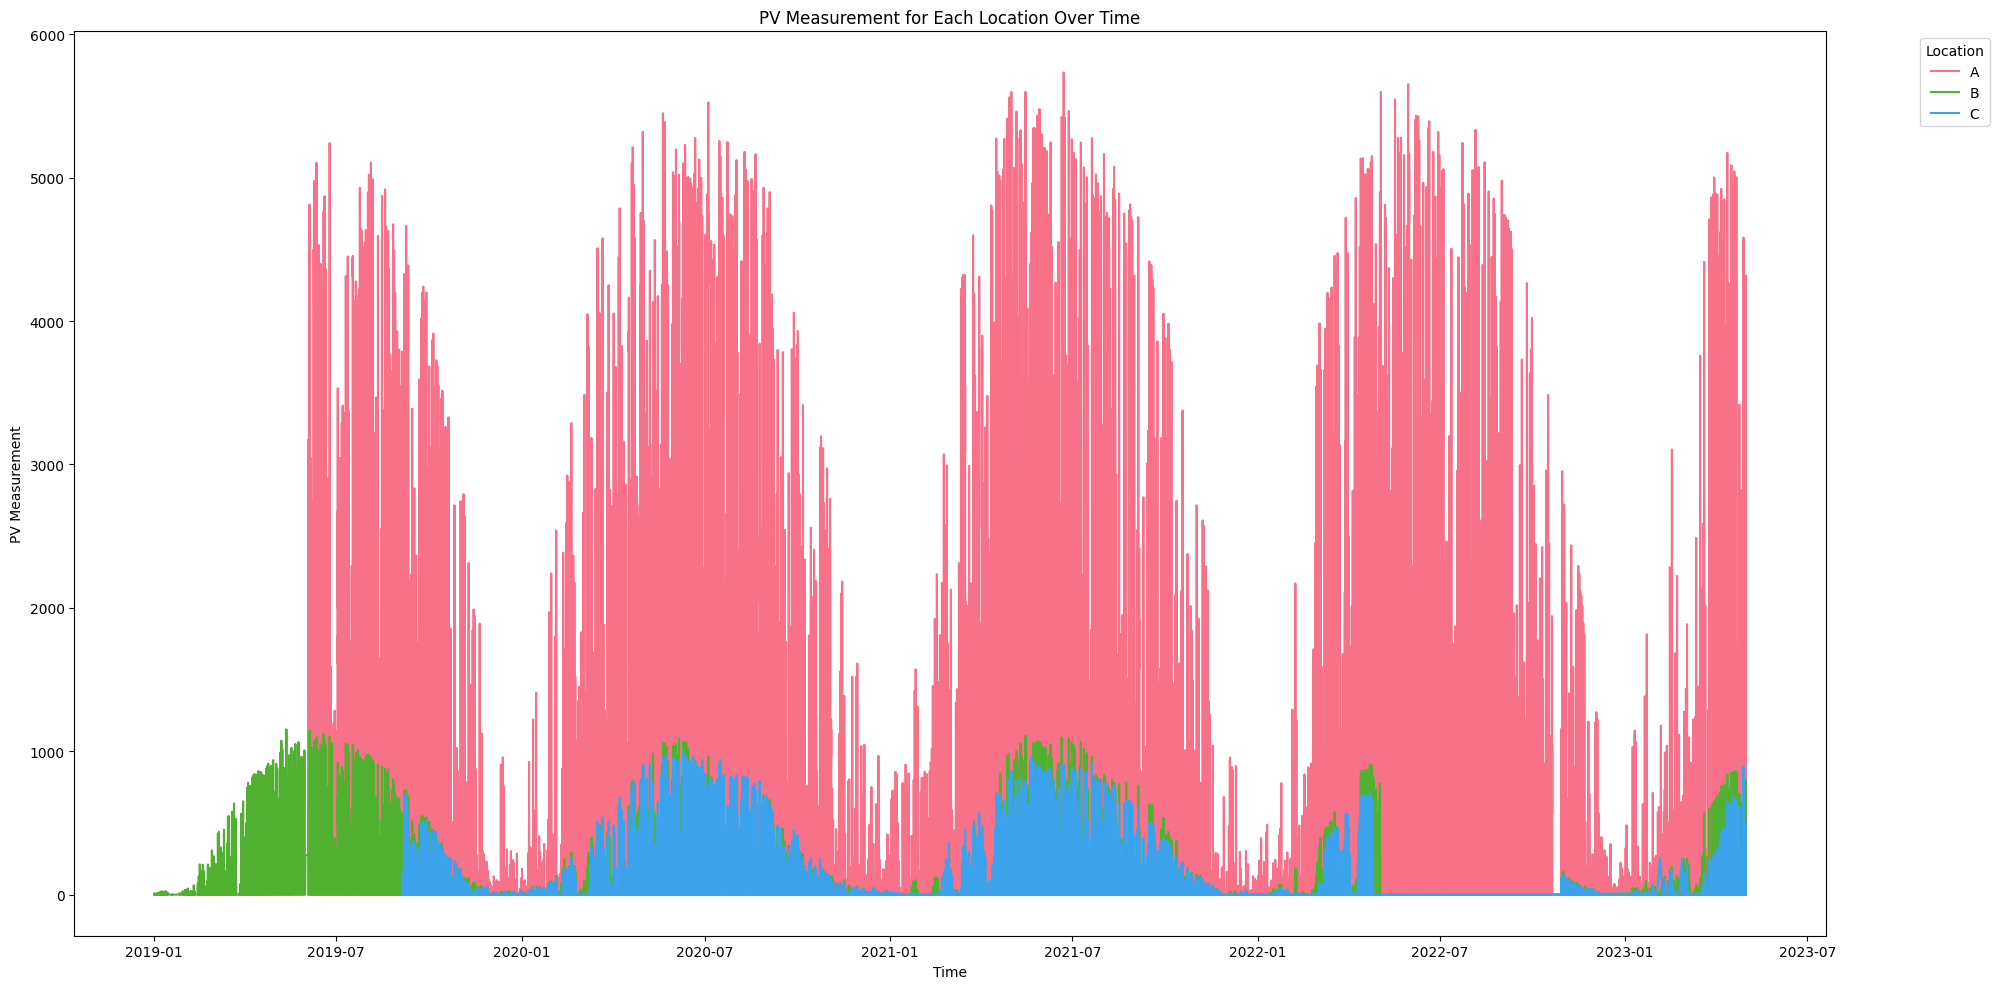

In [97]:
# Read the CSV file
df = pd.read_csv('all_locations.csv')  # Replace with the path to your CSV file

# Filter relevant columns
df_filtered = df[['time', 'pv_measurement', 'location']]

# Convert 'time' column to datetime format for plotting
df_filtered['time'] = pd.to_datetime(df_filtered['time'])

# Define a color palette for better differentiation between locations
palette = sns.color_palette("husl", len(df_filtered['location'].unique()))

# Plot the data
plt.figure(figsize=(20, 10))
sns.lineplot(x='time', y='pv_measurement', hue='location', data=df_filtered, palette=palette)
plt.title('PV Measurement for Each Location Over Time')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

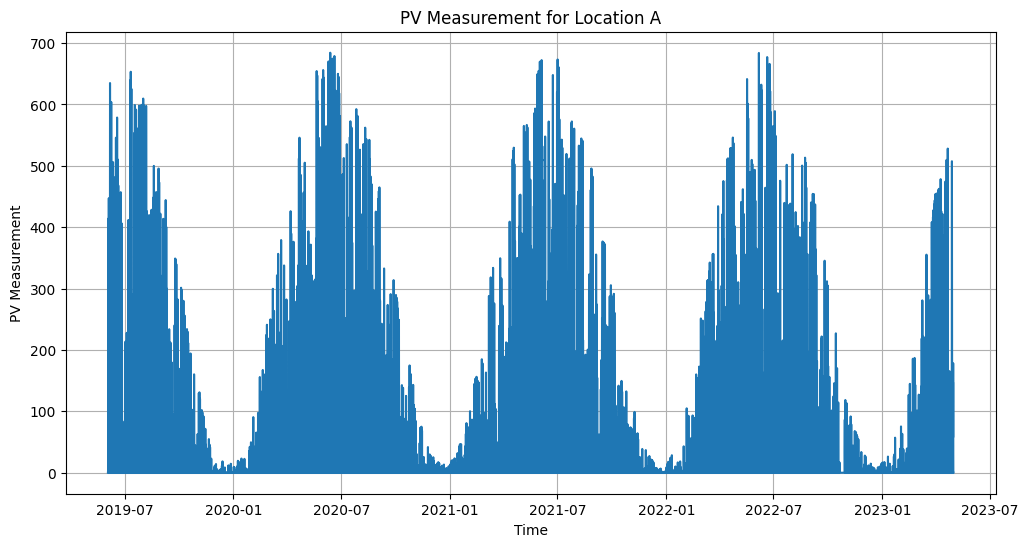

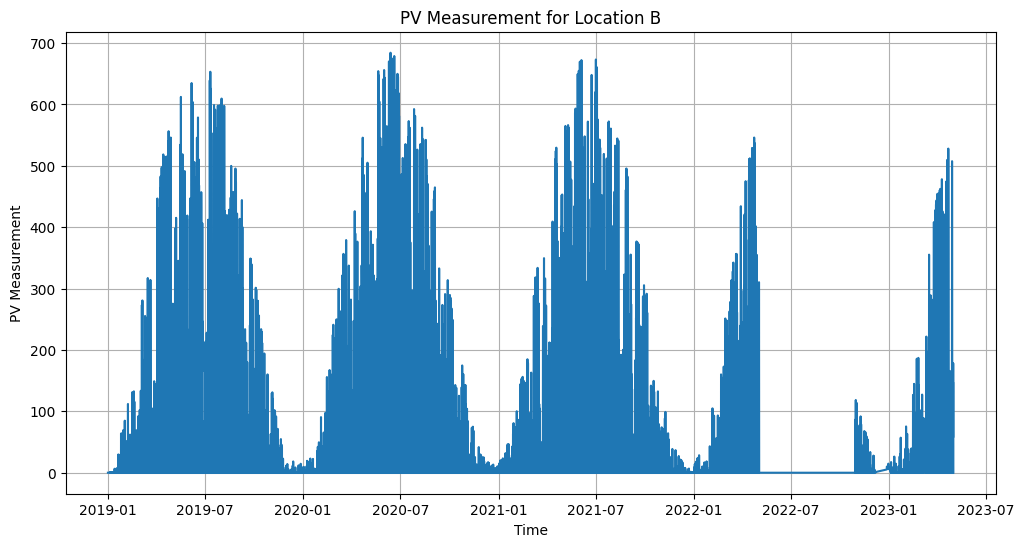

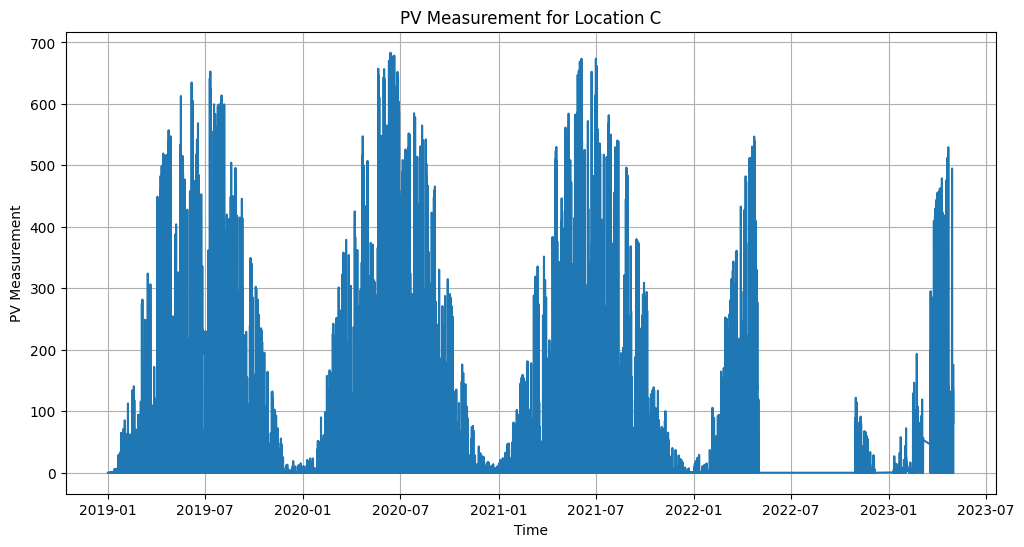

In [98]:
# Identify unique locations in the dataset
unique_locations = df['location'].unique()

# Loop through each unique location to plot the data
for loc in unique_locations:
    # Filter the data for the current location
    df_filtered = df[df['location'] == loc]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df_filtered['time']), df_filtered['direct_rad:W'])

    # Customize the plot
    plt.title(f'PV Measurement for Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.grid(True)

    # Show the plot
    plt.show()


First we look at the target variable across each of the locations. As we see, location A looks to be quite good, but B and C may have some major problems in the time series. We will look at the data in more detail to see if we can find any problems. First we look at location A.

## FIND THE MISSING VALUES IN B AND C.
### COULD BE DONE BY:
Decompose the time series of location A into trend, seasonal, and residual components.
Fit an ARIMA model on the decomposed series.
Predict the missing values for location C using the model and the scaling factor between locations A and C. 

### COULD BE DONE BY:
USE A XGBOOST MODEL TRAINED ON A AND SCALE THE PREDICTIONS FOR B AND C. 

### COULD BE DONE BY:
CALCULATING THE AVERAGE SCALING FACTOR BETWEEN A AND B & C: FILL THE MISSING VALUE BASED ON THIS. 

### COULD BE DONE BY:
HANDLE THIS AS A NORMAL REGRESSION PROBLEM AND REMOVE ROWS WITH MISSING VALUES. 

# Location A

In [99]:
# Read the CSV files
train_targets = pd.read_parquet('./data/A/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/A/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')

We start by describing the data we want to explore.

In [100]:
# Describe the training targets
X_test_estimated.describe().T

,count,mean,min,25%,50%,75%,max,std
date_calc,2880,2023-06-04 17:24:20.700000,2023-04-30 07:00:04,2023-05-22 07:00:04,2023-06-02 19:00:22,2023-06-18 07:00:05,2023-07-02 07:00:31,NaN
date_forecast,2880,2023-06-05 22:16:30,2023-05-01 00:00:00,2023-05-23 11:56:15,2023-06-03 23:52:30,2023-06-19 11:48:45,2023-07-03 23:45:00,NaN
absolute_humidity_2m:gm3,2880.0,8.205903,3.2,6.7,8.1,10.0,13.8,2.179117
air_density_2m:kgm3,2880.0,1.23315,1.151,1.209,1.2385,1.26,1.3,0.032109
ceiling_height_agl:m,2087.0,3061.526611,53.299999,954.099976,1664.300049,4082.700195,11443.900391,2936.846924
clear_sky_energy_1h:J,2880.0,1227651.25,0.0,54776.375977,1046824.5625,2355268.5625,3005374.75,1104096.5
clear_sky_rad:W,2880.0,341.014008,0.0,14.325,290.5,655.350006,836.299988,307.64325
cloud_base_agl:m,2582.0,1866.812988,30.200001,509.100006,1048.0,2394.5,11256.700195,2108.218262
dew_or_rime:idx,2880.0,0.034722,0.0,0.0,0.0,0.0,1.0,0.183107
dew_point_2m:K,2880.0,280.800171,268.100006,278.0,281.100006,284.399994,289.700012,4.340125


In [101]:
X_train_observed.describe().T

,count,mean,min,25%,50%,75%,max,std
date_forecast,118669,2021-02-09 23:30:00,2019-06-02 22:00:00,2020-04-06 22:45:00,2021-02-09 23:30:00,2021-12-16 00:15:00,2022-10-21 01:00:00,NaN
absolute_humidity_2m:gm3,118669.0,6.652576,0.7,4.4,6.3,8.6,17.5,2.796349
air_density_2m:kgm3,118669.0,1.249064,1.145,1.224,1.247,1.272,1.427,0.036319
ceiling_height_agl:m,96422.0,2907.949219,27.799999,1102.900024,1882.400024,3969.75,12328.5,2570.413086
clear_sky_energy_1h:J,118669.0,599401.75,0.0,0.0,35747.699219,1037818.8125,3005720.25,879542.3125
clear_sky_rad:W,118669.0,166.500381,0.0,0.0,8.6,288.799988,836.400024,244.945358
cloud_base_agl:m,110603.0,1737.142212,27.9,590.700012,1162.599976,2079.600098,11688.700195,1815.584106
dew_or_rime:idx,118669.0,0.022398,-1.0,0.0,0.0,0.0,1.0,0.190367
dew_point_2m:K,118669.0,276.823395,250.899994,272.100006,277.200012,282.0,293.799988,6.701763
diffuse_rad:W,118669.0,44.918282,0.0,0.0,4.1,76.0,345.700012,64.786697


In [102]:
X_train_estimated.describe().T

,count,mean,min,25%,50%,75%,max,std
date_calc,17576,2023-01-27 19:07:13.160673,2022-10-27 07:00:18,2022-12-12 08:00:05,2023-01-28 08:00:04,2023-03-15 08:00:04,2023-04-29 07:00:05,NaN
date_forecast,17576,2023-01-28 23:11:50.127446,2022-10-28 22:00:00,2022-12-13 16:26:15,2023-01-29 10:52:30,2023-03-16 05:18:45,2023-04-30 23:45:00,NaN
absolute_humidity_2m:gm3,17576.0,4.092438,1.0,3.0,3.9,5.1,8.8,1.51115
air_density_2m:kgm3,17576.0,1.281746,1.212,1.262,1.279,1.301,1.374,0.03005
ceiling_height_agl:m,13657.0,3257.459473,27.9,1185.5,2750.0,4775.5,12307.700195,2501.79834
clear_sky_energy_1h:J,17576.0,237126.34375,0.0,0.0,0.0,137487.355469,2555980.0,517343.46875
clear_sky_rad:W,17576.0,65.868149,0.0,0.0,0.0,37.400002,711.599976,144.162888
cloud_base_agl:m,15482.0,1575.233032,27.799999,497.524994,935.75,1919.599976,10813.700195,1718.795166
dew_or_rime:idx,17576.0,0.00899,-1.0,0.0,0.0,0.0,1.0,0.22154
dew_point_2m:K,17576.0,270.222351,254.699997,266.799988,270.399994,273.899994,282.100006,5.215952


In [103]:
train_targets.describe().T

,count,mean,min,25%,50%,75%,max,std
time,34085,2021-05-14 00:29:51.497726,2019-06-02 22:00:00,2020-05-22 23:00:00,2021-05-13 00:00:00,2022-05-03 01:00:00,2023-04-30 23:00:00,NaN
pv_measurement,34085.0,630.594707,0.0,0.0,5.94,678.04,5733.42,1165.902422


From these to descriptions we can see that X_train_observed stops where X_train_estimated start. This gives us an intuition to concat the two datasets.

We also see that the date_forecast feature contains values for each quarter of an hour. This needs to be fixed since train_targets only contain values for each hour.

In [104]:
df = pd.concat([X_train_observed, X_train_estimated])

In [105]:
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')

Merging the train_targets into df to make it easier with analysis later on. This also removed each value not containing a whole hour.

## 1. Datatypes and structure
It can be wise to investigate the dataset and visualize how it is structured.

In [138]:
# Size of the dataset
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

print()

# Count how mnay times each datatype appears
print("Data types: ")
print(df.dtypes.value_counts())

print()

# Display all non-time features
print("All float features: ")
print(df.select_dtypes(include=['float32']).columns)

# Display all time features
print("All date time features: ")
print(df.select_dtypes(include=['datetime64[ns]']).columns)

Number of rows:  32130
Number of columns:  57

Data types: 
float32           45
float64            5
int32              4
datetime64[us]     3
Name: count, dtype: int64

All float features: 
Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:

This shows that we have three datetime columns. Let's further explore what these are:

## 1.1 Non-numeric features

In [144]:
df.select_dtypes(exclude='number').head()

,date_forecast,date_calc,time
0,2019-01-01 00:00:00,NaT,2019-01-01 00:00:00
1,2019-01-01 01:00:00,NaT,2019-01-01 01:00:00
2,2019-01-01 02:00:00,NaT,2019-01-01 02:00:00
3,2019-01-01 03:00:00,NaT,2019-01-01 03:00:00
4,2019-01-01 04:00:00,NaT,2019-01-01 04:00:00


From this we can extract two major points of information: 
- First of all, we have 24hrs of data for just about each day in the dataset. 
- Secondly, after merging the X_train_observed, X_train_estimated and train_targets we now have these three datetime columns. From this we see: date_calc contain Nat values, date_forecast and time has the same values. These findings indicate that we can remove either time or date_forecast and have to look deeper into date_calc.

In [108]:
df['date_calc'].describe()

count                          4394
mean     2023-01-27 19:07:13.160673
min             2022-10-27 07:00:18
25%             2022-12-12 08:00:05
50%             2023-01-28 08:00:04
75%             2023-03-15 08:00:04
max             2023-04-29 07:00:05
Name: date_calc, dtype: object

When describing the feature we can see that it has values for almost a year. This may indicate that something went wrong when either concating or merging the datasets. Let's investigate:

In [109]:
X_train_estimated[['date_forecast', 'date_calc']].head()

,date_forecast,date_calc
0,2022-10-28 22:00:00,2022-10-27 07:00:18
1,2022-10-28 22:15:00,2022-10-27 07:00:18
2,2022-10-28 22:30:00,2022-10-27 07:00:18
3,2022-10-28 22:45:00,2022-10-27 07:00:18
4,2022-10-28 23:00:00,2022-10-27 07:00:18


From this we can see that date_calc indicates which day a forecast was calculated. Based on this, we can for now safely remove it.

In [110]:
df = df.drop(columns=['date_calc', 'date_forecast'])
df.select_dtypes(exclude='number').head()

,time
0,2019-06-02 22:00:00
1,2019-06-02 23:00:00
2,2019-06-03 00:00:00
3,2019-06-03 01:00:00
4,2019-06-03 02:00:00


In [111]:
df.describe(exclude='number')

,time
count,34061
mean,2021-05-13 13:58:16.843897
min,2019-06-02 22:00:00
25%,2020-05-22 17:00:00
50%,2021-05-12 12:00:00
75%,2022-05-02 07:00:00
max,2023-04-30 23:00:00


We have a total of 34.061 rows of data, ranging from the mid of June 2019 to the mid of April 2023

## 1.2 Numeric features

<Axes: >

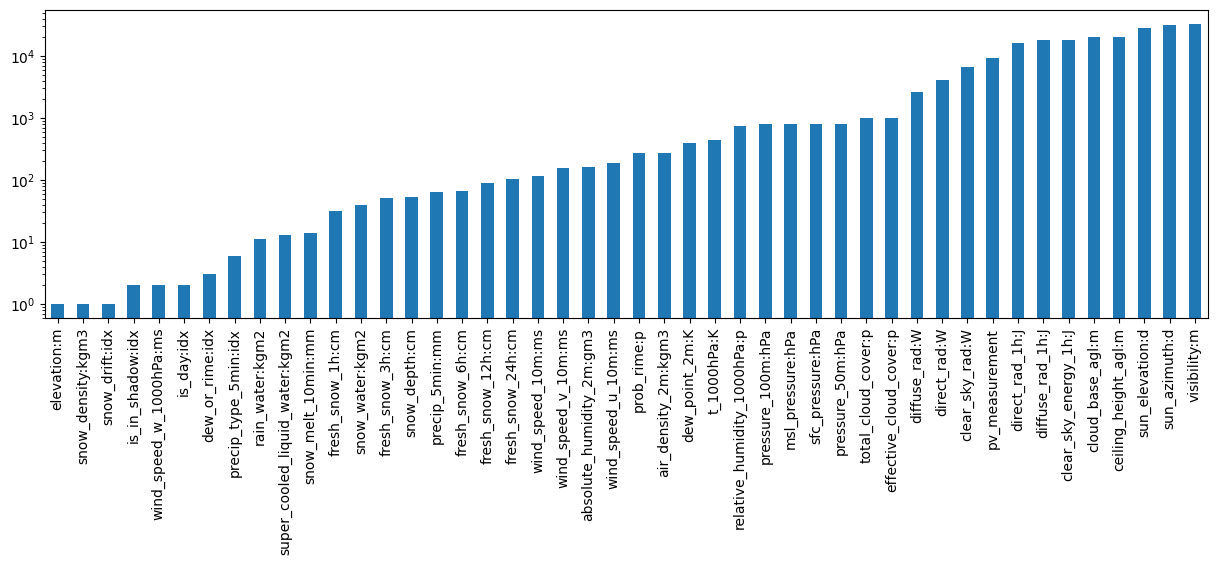

In [112]:
unique_values = df.select_dtypes(exclude='datetime').nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4))

From this we can see that most features are continuous, but three of the features are single valued. This means that they only have one value across all rows. This is something we need to investigate further:

In [113]:
df[['elevation:m', 'snow_density:kgm3', 'snow_drift:idx']].head(20)

,elevation:m,snow_density:kgm3,snow_drift:idx
0,6.0,NaN,0.0
1,6.0,NaN,0.0
2,6.0,NaN,0.0
3,6.0,NaN,0.0
4,6.0,NaN,0.0
5,6.0,NaN,0.0
6,6.0,NaN,0.0
7,6.0,NaN,0.0
8,6.0,NaN,0.0
9,6.0,NaN,0.0


These features have major issues and can therefor be removed from the dataset

In [114]:
df = df.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'], axis=1)
pd.value_counts(df.dtypes)

/var/folders/y3/2mtrz03n77j2nhqjpj_67ptm0000gn/T/ipykernel_1378/1213330515.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df.dtypes)


float32           42
datetime64[us]     1
float64            1
Name: count, dtype: int64

As we can see, we now have three less float32 features, meaning that the features was properly removed.

# 2. Quality check

In [115]:
df.isna().sum()

absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m              7777
clear_sky_energy_1h:J                0
clear_sky_rad:W                      0
cloud_base_agl:m                  3063
dew_or_rime:idx                      0
dew_point_2m:K                       0
diffuse_rad:W                        0
diffuse_rad_1h:J                     0
direct_rad:W                         0
direct_rad_1h:J                      0
effective_cloud_cover:p              0
fresh_snow_12h:cm                    0
fresh_snow_1h:cm                     0
fresh_snow_24h:cm                    0
fresh_snow_3h:cm                     0
fresh_snow_6h:cm                     0
is_day:idx                           0
is_in_shadow:idx                     0
msl_pressure:hPa                     0
precip_5min:mm                       0
precip_type_5min:idx                 0
pressure_100m:hPa                    0
pressure_50m:hPa                     0
prob_rime:p              

We have a total of 7777 missing values in ceiling_height_agl:m and 3063 missing values in cloud_base_agl:m. There are too many missing values to remove the rows containing them, and we don't know the importance of the features yet, so we can't just remove them. Our only choice is then to impute them. A normal strategy for numeric features is using the mean of this feature:

In [116]:
imputer = SimpleImputer(strategy='mean')
df[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(df[['ceiling_height_agl:m', 'cloud_base_agl:m']])

In [117]:
df.isna().sum()

absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                       0
rain_water:kgm2                   0
relative_humidity_1000hPa:p 

All the null values is now removed

# REMEMBER TO FIND OUTLIERS

# 3. Shallow Feature Information
Considering the dimensionality of the dataset, analyzing each feature independently is close to impossible. Therefor, we will first plot each feature and only comment those with some interesting values.

## 3.1 Feature Distributions

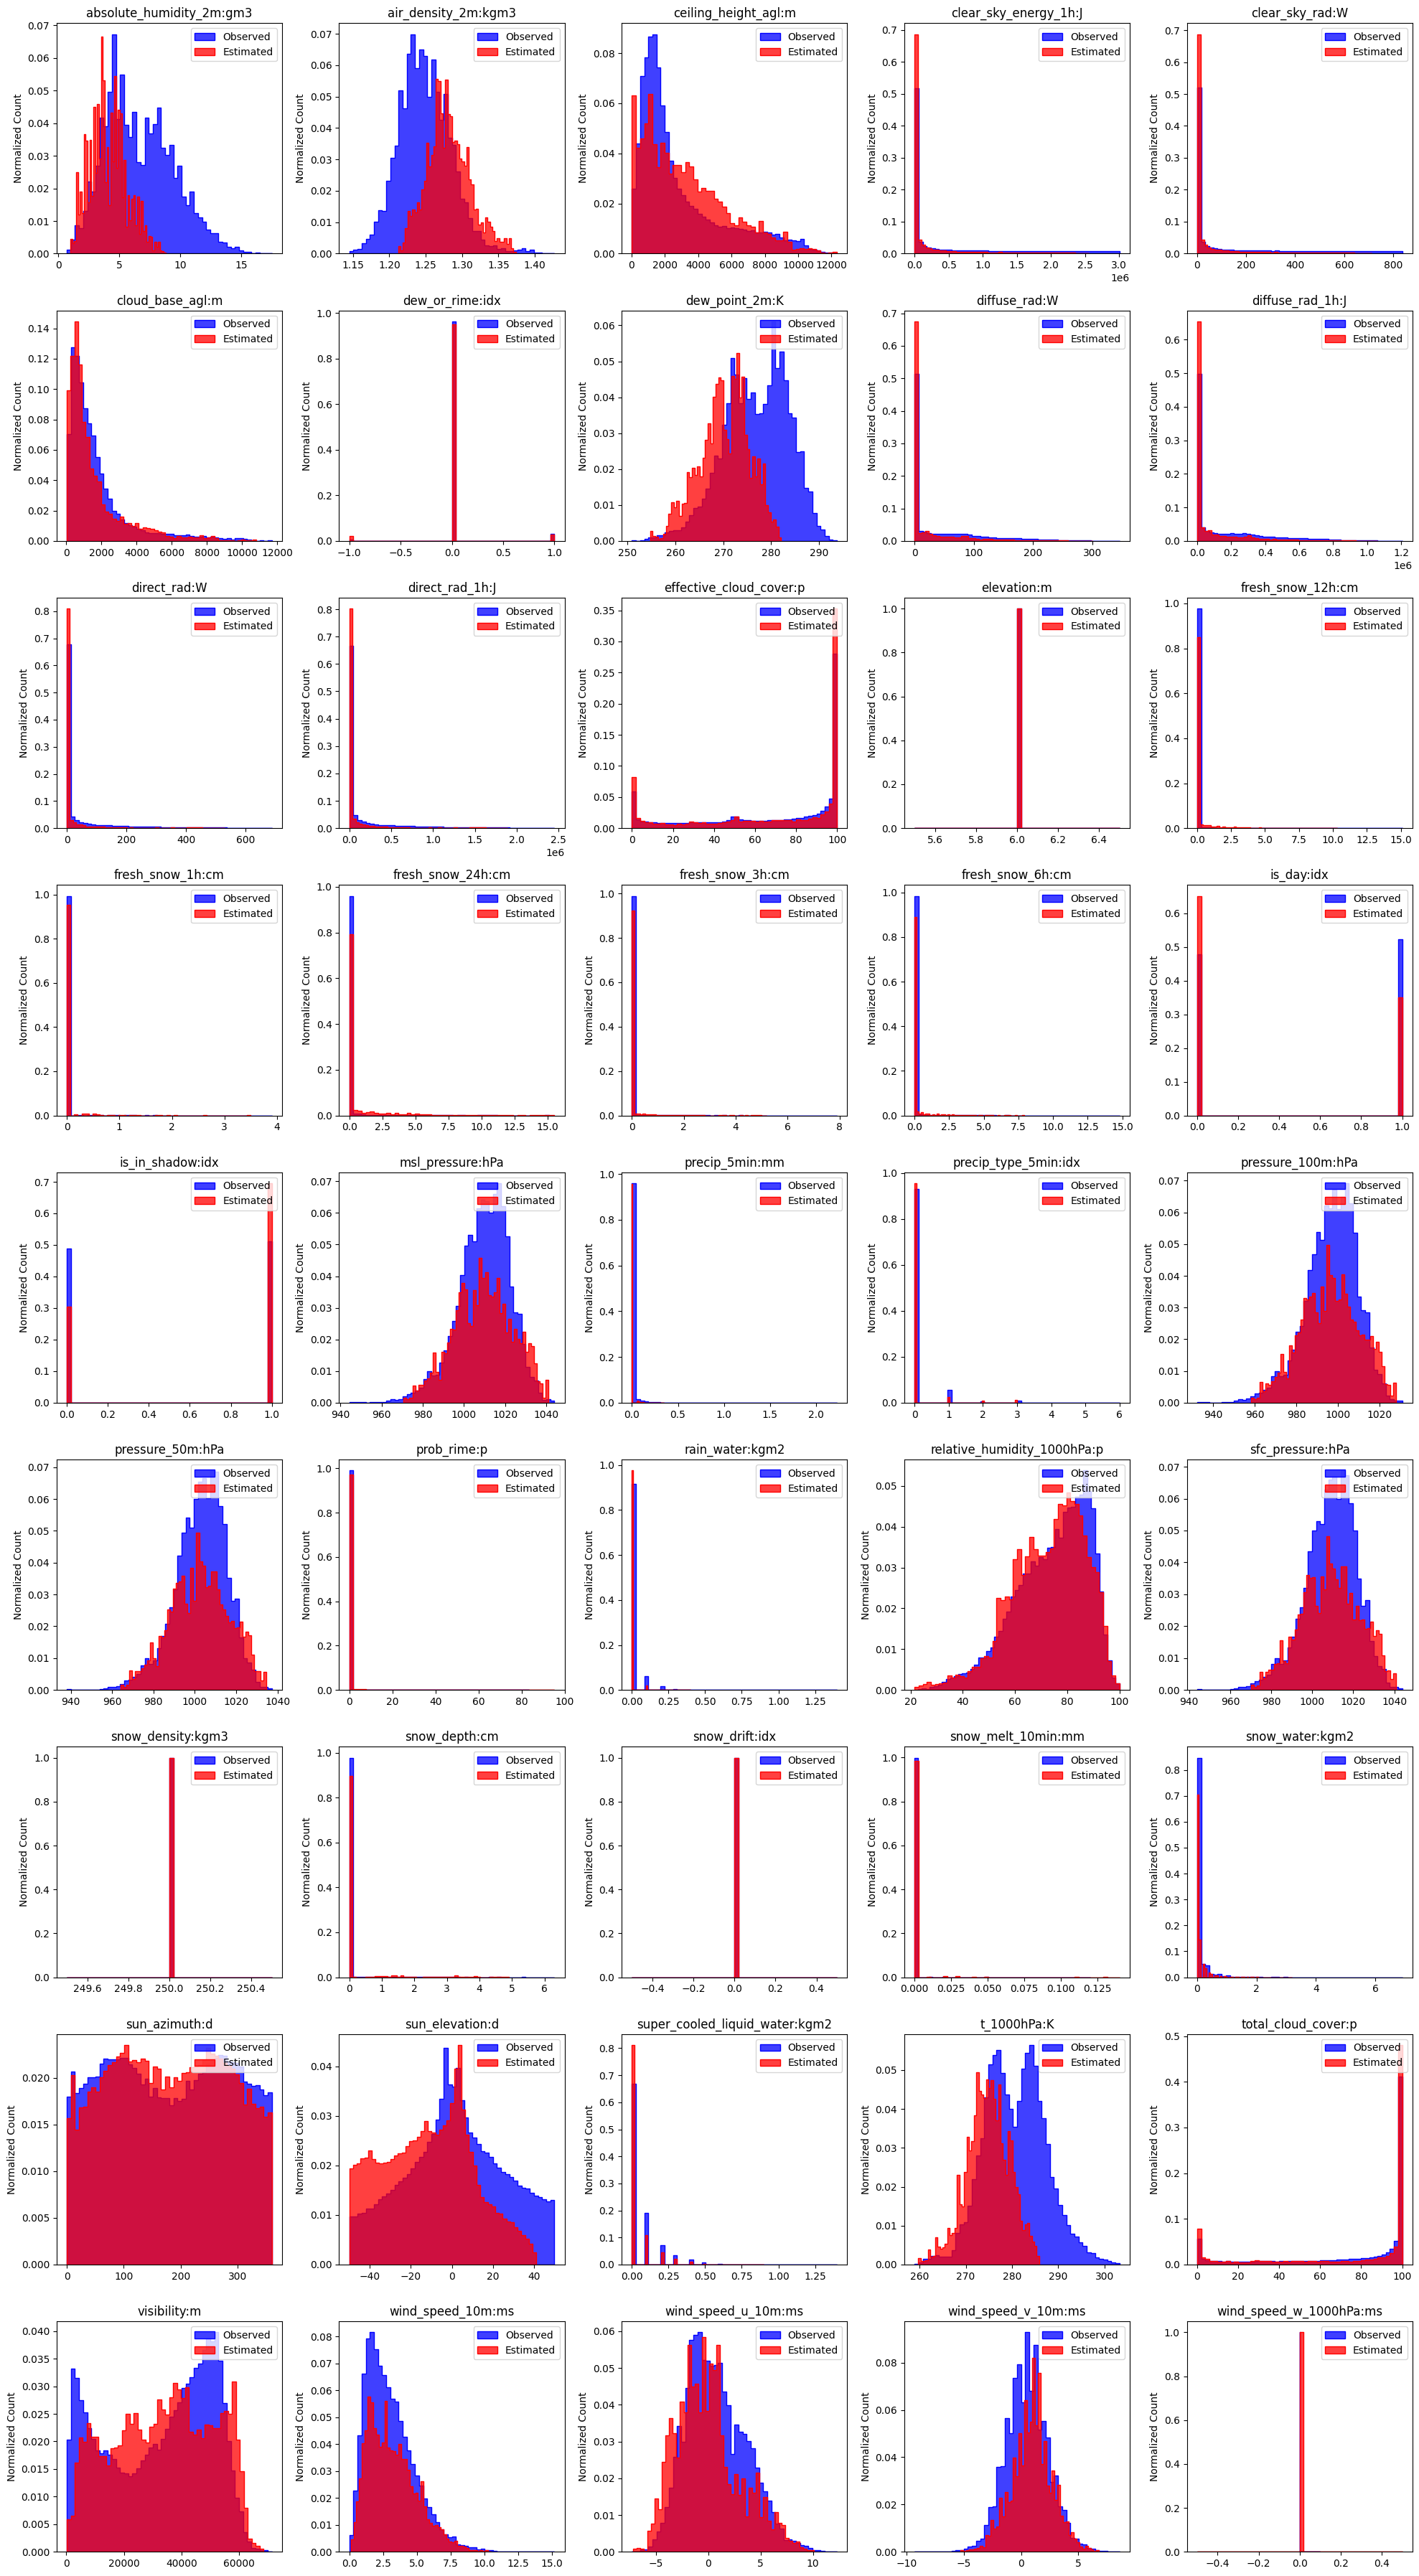

In [118]:
# Drop the index and target variable columns for feature distribution analysis
X_observed = X_train_observed.drop(columns=['date_forecast'])
X_estimated = X_train_estimated.drop(columns=['date_forecast'])
def plot_grid_feature_distributions(observed_df, estimated_df):
    features = observed_df.columns
    num_features = len(features)
    num_rows = -(-num_features // 5)  # Calculate rows needed, rounding up
    
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))
    axes = axes.flatten()  # Flatten the 2D array to 1D
    
    for i, feature in enumerate(features):
        ax = axes[i]
        sns.histplot(observed_df[feature], kde=False, bins=50, color='b', label='Observed', stat='probability', ax=ax, element='step')
        sns.histplot(estimated_df[feature], kde=False, bins=50, color='r', label='Estimated', stat='probability', ax=ax, element='step')
        ax.set_title(f'{feature}')
        ax.set_xlabel('')
        ax.set_ylabel('Normalized Count')
        ax.legend()
    
    # Remove extra subplots
    for i in range(num_features, num_rows * 5):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the grid
plot_grid_feature_distributions(X_observed, X_estimated)

absolute_humidity_2m:gm3: Shows a bimodal distribution, indicating two distinct groups or conditions in the dataset.

air_density_2m:kgm3: Almost normally distributed but has some outliers on the lower end.

ceiling_height_agl:m: Highly skewed to the right, meaning most of the values are clustered at the lower end.

clear_sky_energy_1h:J: Most values are zero, but there are some with higher values, indicating specific conditions where clear sky energy is non-zero.

total_cloud_cover:p: The distribution is almost binary, with most values at either 0 or 100, indicating clear sky or full cloud cover.

visibility:m: This feature also shows a bimodal distribution, indicating two different visibility conditions.

pv_measurement: Highly skewed towards the left. Indicating, most of the time, the solar power consumption is very low.

## 3.2 Linear Correlations

Highly Interdependent Features:
pressure_50m:hPa, sfc_pressure:hPa, and pressure_100m:hPa: These features have correlations very close to 1, indicating they are almost identical. One or two of these could likely be removed without losing much information.

dew_point_2m:K and absolute_humidity_2m:gm3: With a correlation of approximately 0.97, these variables are highly interrelated, suggesting redundancy.

clear_sky_energy_1h:J and clear_sky_rad:W: These also have a very high correlation of approximately 0.99, indicating potential redundancy.

Weather and Time-related Features:
fresh_snow_24h:cm, fresh_snow_12h:cm, fresh_snow_6h:cm, fresh_snow_3h:cm, and fresh_snow_1h:cm: These features are highly correlated with each other, ranging from 0.78 to 0.95, indicating they carry similar information about snowfall over different time periods.

solar_zenith_angle:d and sun_elevation:d: These features have a high negative correlation of -0.99, which makes sense because as the sun rises, the solar zenith angle decreases.

Correlations with Target Variable (pv_measurement):
clear_sky_energy_1h:J: This feature has a high positive correlation of 0.78 with the target variable 'pv_measurement', signifying its importance in predicting the target.

sun_elevation:d: This feature also shows a high positive correlation of 0.76 with the target variable, indicating its relevance in predicting solar energy production.

Other Interesting Correlations:
air_density_2m:kgm3 and t_1000hPa:K: These features have a high negative correlation of -0.91, which is logical given the inverse relationship between air density and temperature.

## 3.3 Non-linear Correlations

Highly Interdependent Features:
pressure_50m:hPa, sfc_pressure:hPa, and pressure_100m:hPa: These features have near-perfect Spearman correlations, suggesting they convey almost identical information. Consider dropping some to remove redundancy.

dew_point_2m:K and absolute_humidity_2m:gm3: With a Spearman correlation of around 0.97, these features are highly associated and possibly redundant.

clear_sky_energy_1h:J and clear_sky_rad:W: These have a Spearman correlation of around 0.99, further confirming their redundancy.

Weather and Time-related Features:
fresh_snow_24h:cm, fresh_snow_12h:cm, fresh_snow_6h:cm, fresh_snow_3h:cm, and fresh_snow_1h:cm: These features show high Spearman correlations ranging from 0.75 to 0.94, indicating they are capturing similar snowfall patterns over different time frames.

solar_zenith_angle:d and sun_elevation:d: Their Spearman correlation is -0.99, which is in line with their natural inverse relationship.

Correlations with Target Variable (pv_measurement):
    clear_sky_energy_1h:J: This has a Spearman correlation of 0.78 with the target variable, emphasizing its importance for prediction.

sun_elevation:d: This feature also has a Spearman correlation of 0.76 with the target variable, underlining its significance.

Other Interesting Correlations:
air_density_2m:kgm3 and t_1000hPa:K: These features have a Spearman correlation of -0.91, suggesting a robust inverse relationship even when accounting for non-linearities.

## 3.4 Correlations Based on Dataset

## 3.5 First Feature Extraction Based on Feature Redundancy

# 4 In-depth Feature Information

## 4.1 Feature Extraction for Further EDA

In [119]:
# Prepare the data
X = df.drop(columns=['pv_measurement', 'time'])  # Drop the index, target, and time columns
y = df['pv_measurement']  # Target variable

## 4.2 Seasonal Decomposition

## 4.3 Stationarity 

## 4.4 Autocorrelation (ACF/PACF)

# Location B

In [120]:
train_targets = pd.read_parquet('./data/B/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/B/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/B/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/B/X_train_observed.parquet')

In [121]:
df = pd.concat([X_train_observed, X_train_estimated])

In [122]:
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')

In [123]:
df.isna().sum()

date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               6475
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   2731
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
precip_type_5min:idx                  0


# Location C

In [124]:
train_targets = pd.read_parquet('./data/C/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/C/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/C/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/C/X_train_observed.parquet')

In [125]:
df = pd.concat([X_train_observed, X_train_estimated])

In [126]:
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')

In [127]:
df.isna().sum()

date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               6813
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   3114
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
precip_type_5min:idx                  0


# 5. Feature Engineering

## 5.1 Time based Features

In [128]:
def date_features(df):
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter

    df['lagged_pv_measurement_1h'] = df['pv_measurement'].shift(1)
    df['lagged_pv_measurement_3h'] = df['pv_measurement'].shift(3)
    df['lagged_pv_measurement_6h'] = df['pv_measurement'].shift(6)

    df['rolling_mean_pv_measurement_3h'] = df['pv_measurement'].rolling(window=3).mean()
    return df

date_features(df)

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,time,pv_measurement,hour,day,month,quarter,lagged_pv_measurement_1h,lagged_pv_measurement_3h,lagged_pv_measurement_6h,rolling_mean_pv_measurement_3h
0,2019-01-01 00:00:00,5.6,1.240,1153.599976,0.000000,0.0,1153.599976,1.0,275.200012,0.0,...,2019-01-01 00:00:00,NaN,0,1,1,1,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,5.3,1.241,1090.599976,0.000000,0.0,1090.599976,1.0,274.500000,0.0,...,2019-01-01 01:00:00,NaN,1,1,1,1,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,5.4,1.238,1026.599976,0.000000,0.0,1026.599976,0.0,274.899994,0.0,...,2019-01-01 02:00:00,NaN,2,1,1,1,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,5.2,1.240,961.700012,0.000000,0.0,961.700012,0.0,274.200012,0.0,...,2019-01-01 03:00:00,NaN,3,1,1,1,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,5.4,1.239,954.900024,0.000000,0.0,954.900024,0.0,274.899994,0.0,...,2019-01-01 04:00:00,NaN,4,1,1,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32125,2023-04-30 19:00:00,4.4,1.274,1474.199951,156770.703125,13.4,557.000000,0.0,272.100006,8.8,...,2023-04-30 19:00:00,50.96,19,120,4,2,175.42,125.44,476.28,138.833333
32126,2023-04-30 20:00:00,4.4,1.278,1427.300049,7917.100098,0.0,541.700012,0.0,272.000000,0.0,...,2023-04-30 20:00:00,2.94,20,120,4,2,50.96,190.12,491.96,76.440000
32127,2023-04-30 21:00:00,4.4,1.279,1558.099976,0.000000,0.0,601.500000,0.0,271.899994,0.0,...,2023-04-30 21:00:00,0.00,21,120,4,2,2.94,175.42,267.54,17.966667
32128,2023-04-30 22:00:00,4.4,1.279,1446.599976,0.000000,0.0,540.700012,0.0,271.899994,0.0,...,2023-04-30 22:00:00,-0.00,22,120,4,2,0.00,50.96,125.44,0.980000


In [129]:
# Make sure to have a column 'id' for each time series and 'time' for the time stamps
# extracted_features = extract_features(df, column_id='id', column_sort='time')